In [1]:
#import the needed modules
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lane import Camera, Line
%matplotlib inline

In [4]:
#####call the function cal_undistort to calculate the camera matrix and distortion coefficients
#####this function only need to be called once
#undistort_parameters(input_files = 'camera_cal/cal*.jpg')

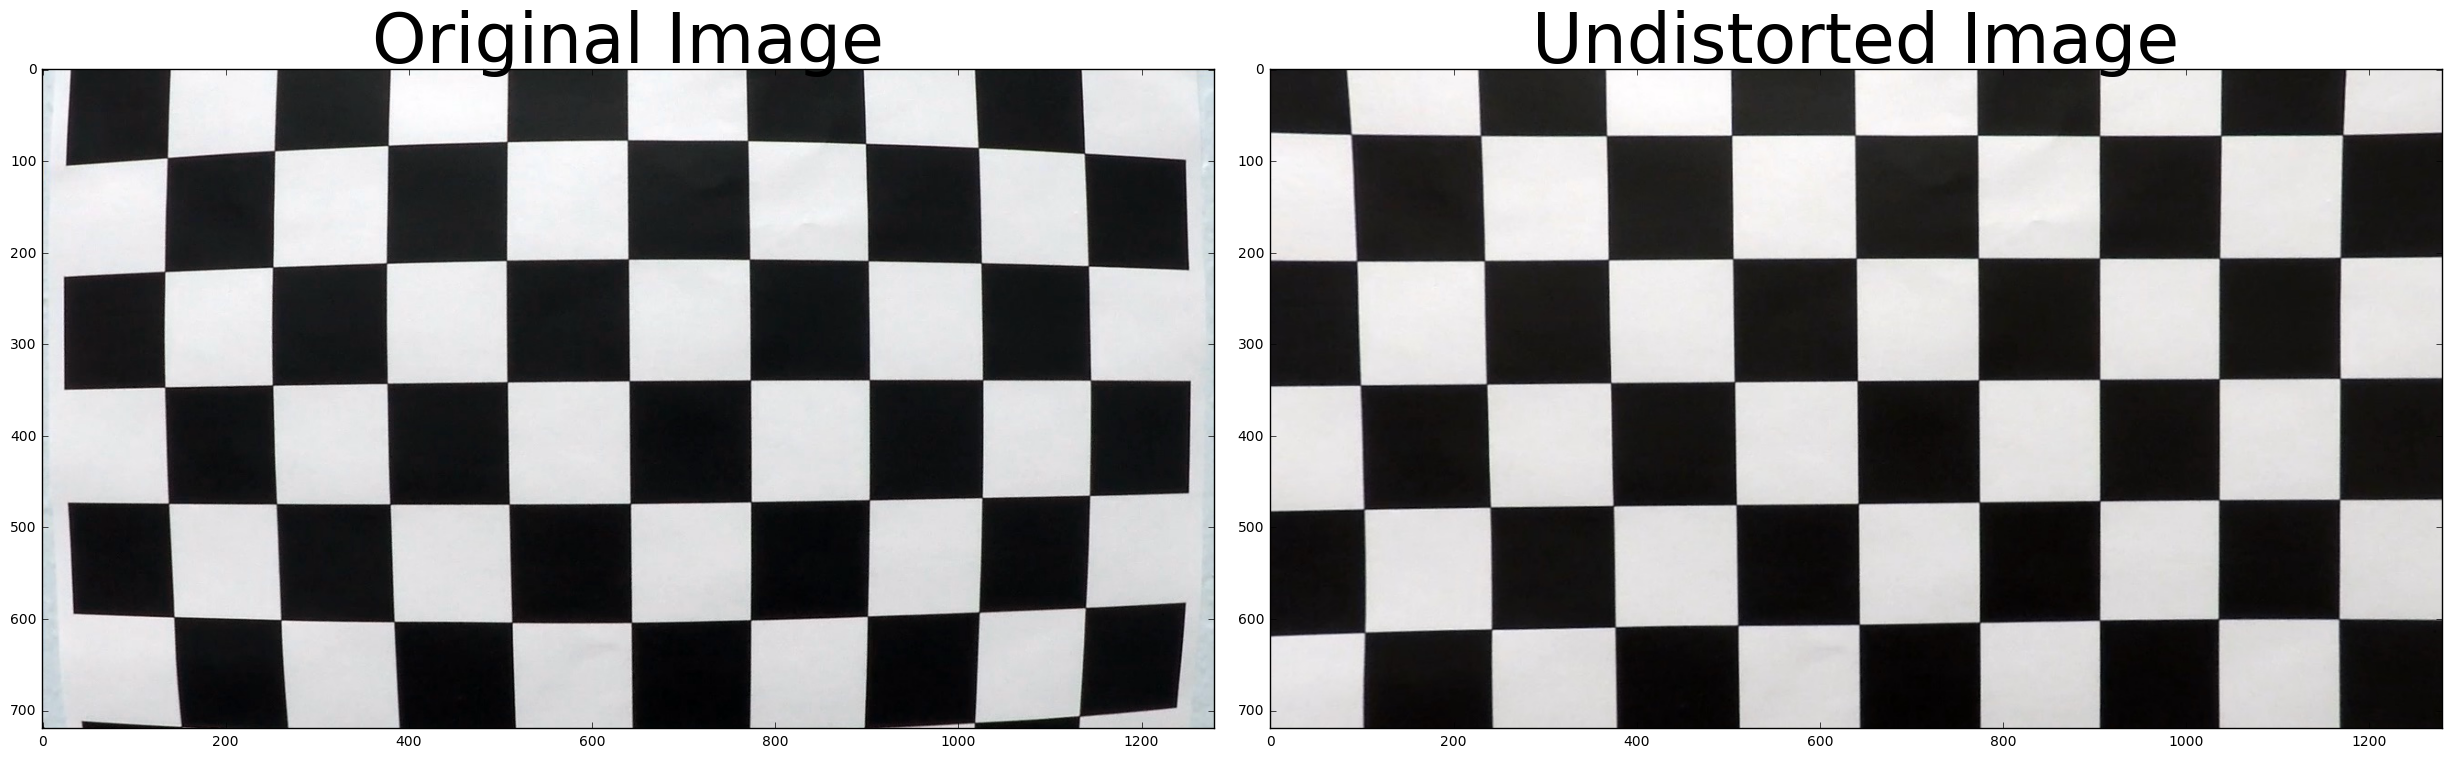

In [2]:
#plot the original image and undistorted image of a cheese board image
img_name = 'camera_cal/test1.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(img,pickle_cal="temp/cal_pickle.p")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.imread(img_name))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/cheeseboard.png')

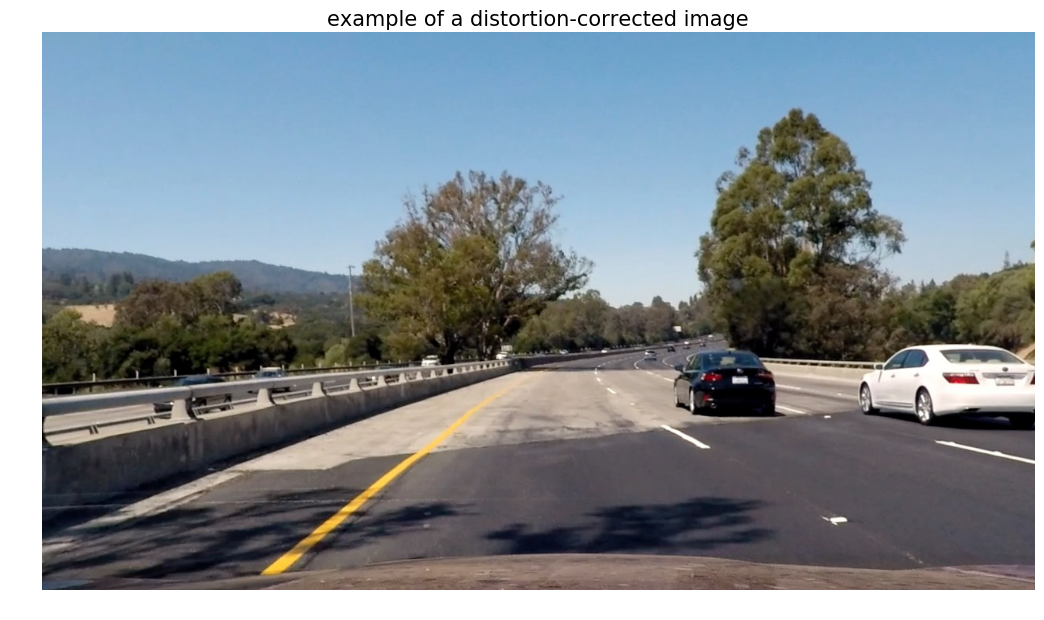

In [4]:
#plot the original image and undistorted image of a road image
#conduct the undistortion
img_name = 'test_images/test4.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(img)
#plot it
plt.figure(figsize=(12.8,7.2))
plt.imshow(undistorted)
plt.axis('off')
plt.title('example of a distortion-corrected image', fontsize=15)
plt.savefig('output_images/distortion_corrected.png')

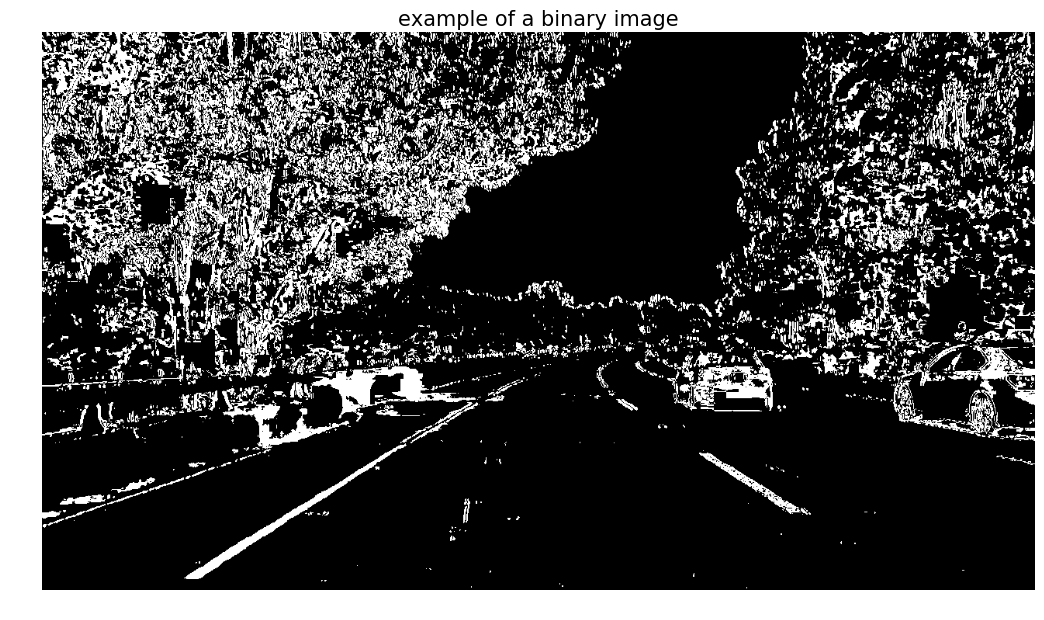

In [5]:
#Test the bianry image produce pipline
img_name = 'test_images/test5.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#read and undistort the image
img = undistort_image(img)
binary_img = get_binary_img(img, (170, 255), (20, 100))
plt.figure(figsize=(12.8,7.2))
plt.imshow(binary_img, cmap='gray')
plt.axis('off')
plt.title('example of a binary image', fontsize=15)
plt.savefig('output_images/binary_image.png')

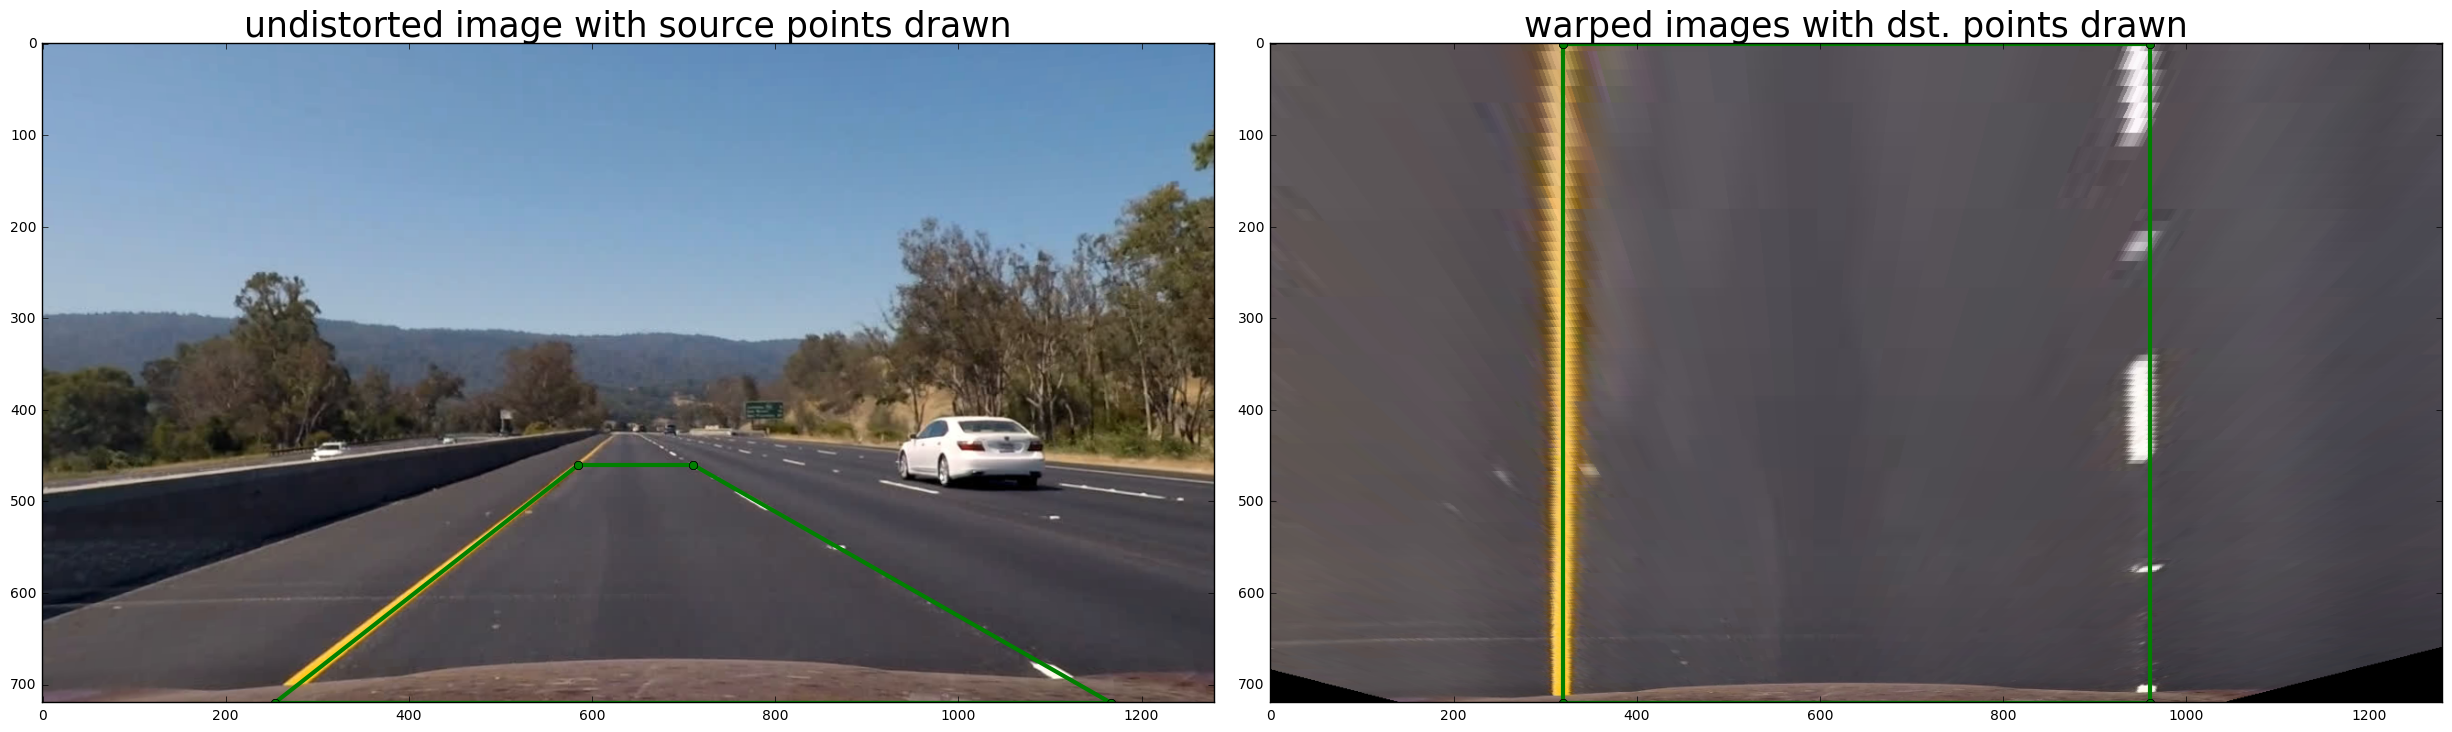

In [7]:
#perspective transform example
#extract a fram frame from the project video and save it
img_name = 'test_images/from_video.jpg'
clip1 = VideoFileClip("project_video.mp4")
clip1.save_frame(img_name, t=16, withmask=True)

#read and undistort the image
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = undistort_image(img)
#call the perspective transform function
src,dst,warped_img = pers_trans(img)
#plot the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot([src[0][0],src[1][0]], [src[0][1],src[1][1]], 'go-', linewidth=3)
ax1.plot([src[1][0],src[2][0]], [src[1][1],src[2][1]], 'go-', linewidth=3)
ax1.plot([src[2][0],src[3][0]], [src[2][1],src[3][1]], 'go-', linewidth=3)
ax1.plot([src[3][0],src[0][0]], [src[3][1],src[0][1]], 'go-', linewidth=3)
ax1.imshow(img)
ax1.set_title('undistorted image with source points drawn', fontsize=25)


ax2.plot([dst[0][0],dst[1][0]], [dst[0][1],dst[1][1]], 'go-', linewidth=3)
ax2.plot([dst[1][0],dst[2][0]], [dst[1][1],dst[2][1]], 'go-', linewidth=3)
ax2.plot([dst[2][0],dst[3][0]], [dst[2][1],dst[3][1]], 'go-', linewidth=3)
ax2.plot([dst[3][0],dst[0][0]], [dst[3][1],dst[0][1]], 'go-', linewidth=3)
ax2.imshow(warped_img)
ax2.set_title('warped images with dst. points drawn', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_transform.png')

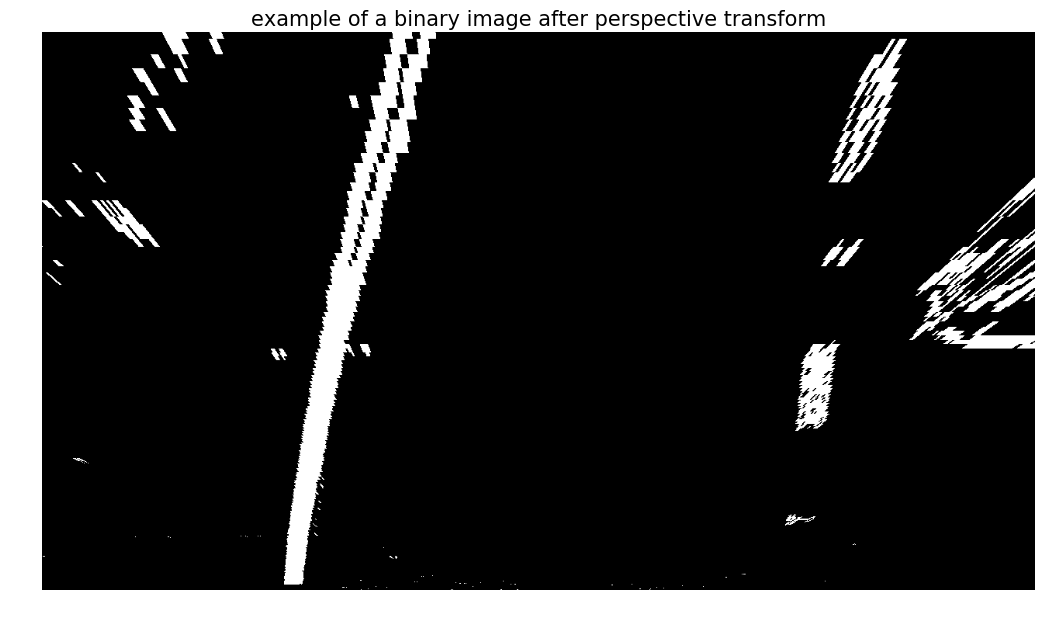

In [8]:
#perspective transform of a binary images

#prepare the image, and src and dst points
img_name = 'test_images/test6.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#read and undistort the image
img = undistort_image(img)
#apply threshold to get the binary image
binary_img = get_binary_img(img, (170, 255), (20, 100))

#call the perspective transform function
src,dst,warped_img = pers_trans(binary_img)
#plot the image
plt.figure(figsize=(12.8,7.2))
plt.imshow(warped_img, cmap='gray')
plt.axis('off')
plt.title('example of a binary image after perspective transform', fontsize=15)
plt.savefig('output_images/binary_image_per_trans.png')

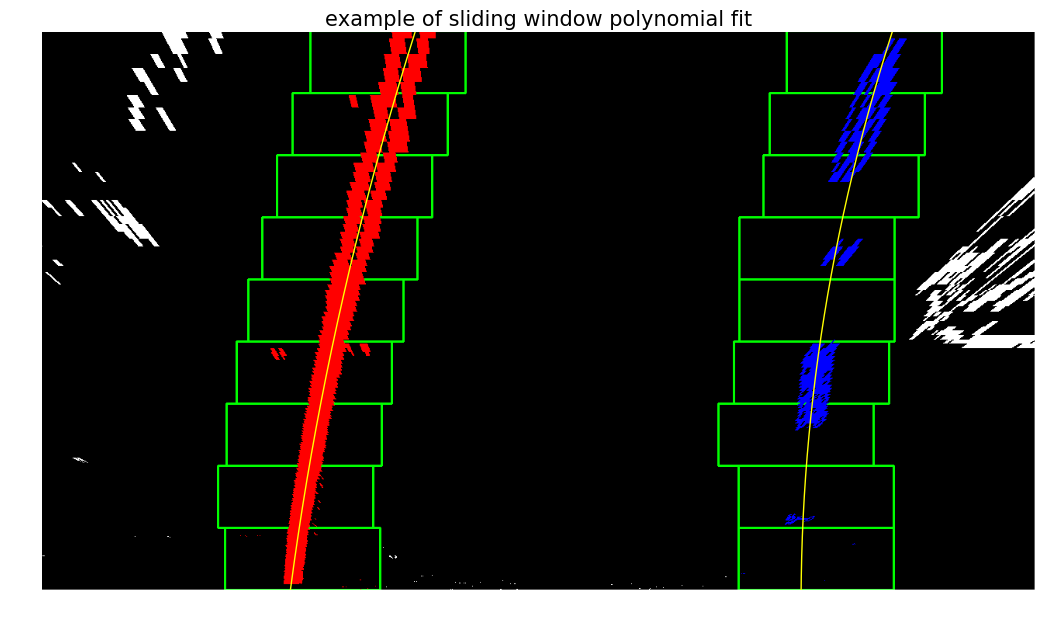

In [9]:
# example of Sliding Windows and Fit a Polynomial
img_name = 'test_images/test6.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#read and undistort the image
img = undistort_image(img)
#apply threshold to get the binary image
binary_img = get_binary_img(img, (170, 255), (20, 100))
#apply the perspective transform
src,dst,binary_warped = pers_trans(binary_img)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# visualize the result
# Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(12.8,7.2))
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis('off')
plt.title('example of sliding window polynomial fit', fontsize=15)
plt.savefig('output_images/slid_win_fit.png')

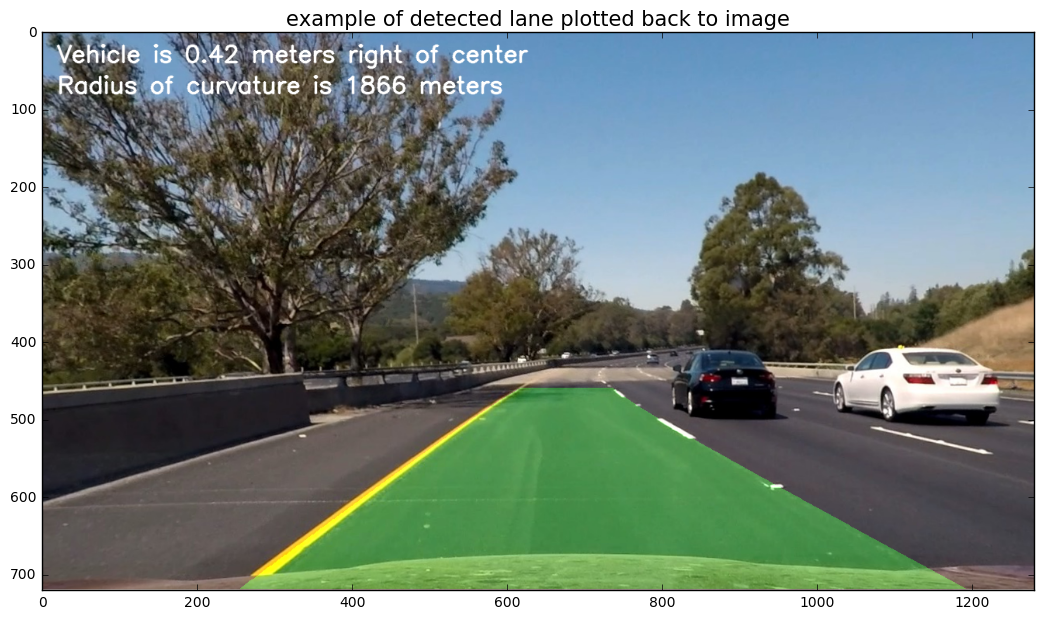

In [3]:
#example calculating the curvature, offsets and lane plotted back to the image
img_name = 'test_images/test6.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = lane_drawing(img)
#plot orignal image, and plot the lane on it, also print the radius of the curvature and offsets
plt.figure(figsize=(12.8,7.2))
plt.imshow(result)
plt.xlim(0, 1280)
plt.ylim(720, 0)
#plt.axis('off')
plt.title('example of detected lane plotted back to image', fontsize=15)
#plt.savefig('output_images/lane_on_image.png'

In [5]:
#process on project video
output1 = 'project_video_solution.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lane_drawing) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [03:54<00:00,  4.57it/s]    | 1/1261 [00:00<02:57,  7.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 14min 32s, sys: 1min 35s, total: 16min 8s
Wall time: 3min 55s


In [6]:
#process on challenge video
output2 = 'challenge_video_solution.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(lane_drawing) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video challenge_video_solution.mp4
[MoviePy] Writing video challenge_video_solution.mp4


100%|██████████| 485/485 [01:11<00:00,  6.43it/s]     | 1/485 [00:00<01:10,  6.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_solution.mp4 

CPU times: user 4min 25s, sys: 30 s, total: 4min 55s
Wall time: 1min 12s
